# Analysis of Classification Models on Most Streamed Spotify Songs Dataset
Dataset: Most Streamed Spotify Songs 2023 (https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data)


## Objective
Using a song's release date, presence in Spotify playlists, charts, as well as other music streaming charts, and various audio features, predict the song's number of streams on Spotify. 

## Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.model_selection import learning_curve, cross_val_score

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
data = pd.read_csv('spotify-2023.csv', encoding='latin1')
data.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## Data Preprocessing


Key features to train our 3 classifiers are:
1. Demographics:
    - Age = 2025 - Year_Birth
    - Education: Undergraduate, Postgraduate
    - Marital Status: Alone, In couple
    - Children: How many children in household (Kidhome + Teenhome)
2. Income
3. Customer Tenure: 
    - Customer_Tenure: Today - Dt_Customer (days since joining)
    - Recency: # of day since last purchase
3. Spending behavior & Engagement:
    - Spending: amount spent on wine, fruits, meat, fish, sweets, and gold in last 2 years
    - Web: NumWebPurchases
    - Catalog: NumCatalogPurchases
    - Store: NumStorePurchases
    - WebVisits: NumWebVisitsMonth (in last month)
    - DealPurchases: NumDealsPurchases
    - CampaignResponse: summation of AcceptedCmpX and Response (0 to 6 for levels of campaign engagement)

In [4]:
mode_df = data.drop_duplicates(subset=['mode'])
print(mode_df['mode'])

key_df = data.drop_duplicates(subset=['key'])
print(key_df['key'])

0    Major
4    Minor
Name: mode, dtype: object
0       B
1      C#
2       F
3       A
9       D
10     F#
12    NaN
15     G#
19      G
33      E
50     A#
95     D#
Name: key, dtype: object


In [5]:
drop_cols = [0, 1]

data = data.drop(data.columns[drop_cols], axis=1)

data['in_shazam_charts'] = pd.to_numeric(data['in_shazam_charts'].str.replace(',',''), errors='coerce')
data.fillna({'in_shazam_charts': data['in_shazam_charts'].median()}, inplace=True)

data.fillna({'key': 'Unknown'}, inplace=True)

input_df = data.drop(['key', 'mode'], axis=1)
input_df2 = data[['key', 'mode']]

# Replace non-numeric values to NaN and NaN with mean
input_df = input_df.apply(pd.to_numeric, errors='coerce')
input_df = input_df.fillna(input_df.mean().round().astype(int))

# Normalize numeric data
input_df = (input_df - input_df.mean()) / input_df.std()
input_df2 = pd.get_dummies(input_df2, columns=['key', 'mode'], drop_first=True)

input_df = pd.concat([input_df, input_df2], axis=1)

input_df.head(15)

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_Unknown,mode_Minor
0,0.497021,0.428366,0.270977,0.007526,-0.588422,6.895720,-0.657929,-0.287040,4.169273,-0.378212,...,False,False,False,False,False,False,False,False,False,False
1,-0.622745,0.428366,-0.850591,0.985580,-0.471804,1.838505,-0.671459,-0.229197,1.463380,-0.302291,...,True,False,False,False,False,False,False,False,False,False
2,-0.622745,0.428366,-0.009415,1.746288,-0.481554,5.158899,-0.660361,0.302954,3.063215,-0.109570,...,False,False,False,False,True,False,False,False,False,False
3,-0.622745,0.068531,0.551369,0.985580,0.336542,4.494820,0.506043,0.557462,3.063215,0.088992,...,False,False,False,False,False,False,False,False,False,False
4,-0.622745,0.428366,-0.289807,0.442217,-0.261741,1.940671,-0.372249,0.187269,1.601637,-0.132930,...,False,False,False,False,False,False,False,False,False,True
5,0.497021,0.428366,-0.009415,-1.405218,-0.381650,4.035073,-0.583225,-0.009396,3.181721,-0.127090,...,True,False,False,False,False,False,False,False,False,False
6,0.497021,0.428366,-0.850591,0.224871,-0.267185,1.940671,0.373911,-0.391157,3.359480,-0.389892,...,False,False,False,False,True,False,False,False,False,True
7,-0.622745,0.428366,0.270977,-0.753182,-0.568036,1.583090,-0.804837,-0.495273,0.732592,-0.465812,...,False,False,False,False,True,False,False,False,False,False
8,-0.622745,0.428366,-0.289807,0.116199,-0.519667,3.626409,-0.739411,-0.090375,3.122468,-0.360692,...,True,False,False,False,False,False,False,False,False,True
9,0.497021,0.428366,-0.850591,0.333544,-0.284532,1.634173,0.069713,-0.217629,1.147364,-0.255571,...,False,True,False,False,False,False,False,False,False,True


## Create Training/Testing Sets

In [6]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = input_df.drop('streams', axis=1)
y = input_df['streams']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)

(762, 31)


## Neural Network Model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

In [8]:
# Function to create the model
def create_model(hidden_layer_sizes=[32, 64, 32], activation='relu', lr=0.001, dropout=0.3):
    model = Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))  # Input layer
    for neurons in hidden_layer_sizes:
        model.add(layers.Dense(neurons, activation=activation)) # Hidden layers
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))  # Output layer 
    model.compile(optimizer=Adam(learning_rate=lr), loss="mean_squared_error")
    return model

# Manually tune hyperparameters
hidden_layer_sizes = [[32, 64, 32], [64, 128, 64], [128, 64, 128]]
activation_functions = ['relu', 'tanh', 'sigmoid']

# Iterate over the hyperparameter combinations
best_score = float('inf')
best_params = None
best_model = None
best_history = None
val_losses = [] 
param_combos = [] 
for hls in hidden_layer_sizes:
    for activation in activation_functions:
        # for dr in dropouts:
        print(f"Training model with hidden layers: {hls}, activation: {activation}")
        
        # Create and train the model
        model = create_model(hidden_layer_sizes=hls, activation=activation)
        history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))
        
        # Evaluate on validation set
        val_loss = model.evaluate(X_test, y_test, verbose=0)
        print(f"Validation Loss: {val_loss}")

        val_losses.append(val_loss)
        param_combos.append(f"{hls}-{activation}")
        
        if val_loss < best_score:
            best_score = val_loss
            best_params = {'hidden_layer_sizes': hls, 'activation': activation}
            best_model = model
            best_history = history

if best_model:
    print("Best Hyperparameters:", best_params)
    print("Best Validation Loss: ", best_score)

Training model with hidden layers: [32, 64, 32], activation: relu
Validation Loss: 0.25755953788757324
Training model with hidden layers: [32, 64, 32], activation: tanh
Validation Loss: 0.22366951406002045
Training model with hidden layers: [32, 64, 32], activation: sigmoid
Validation Loss: 0.21689607203006744
Training model with hidden layers: [64, 128, 64], activation: relu
Validation Loss: 0.268267959356308
Training model with hidden layers: [64, 128, 64], activation: tanh
Validation Loss: 0.2288273125886917
Training model with hidden layers: [64, 128, 64], activation: sigmoid
Validation Loss: 0.19446417689323425
Training model with hidden layers: [128, 64, 128], activation: relu
Validation Loss: 0.24710775911808014
Training model with hidden layers: [128, 64, 128], activation: tanh
Validation Loss: 0.20089825987815857
Training model with hidden layers: [128, 64, 128], activation: sigmoid
Validation Loss: 0.1980350762605667
Best Hyperparameters: {'hidden_layer_sizes': [64, 128, 64],

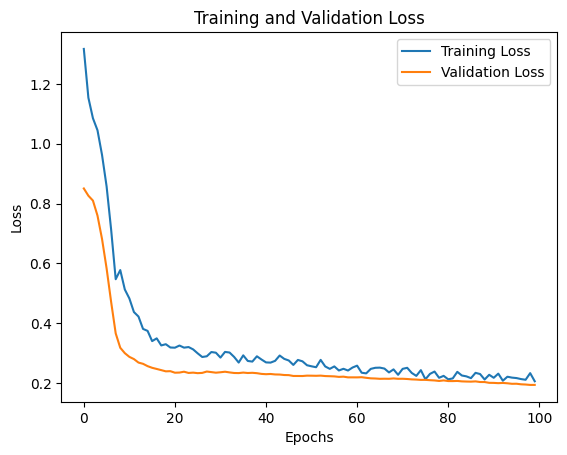

In [9]:
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

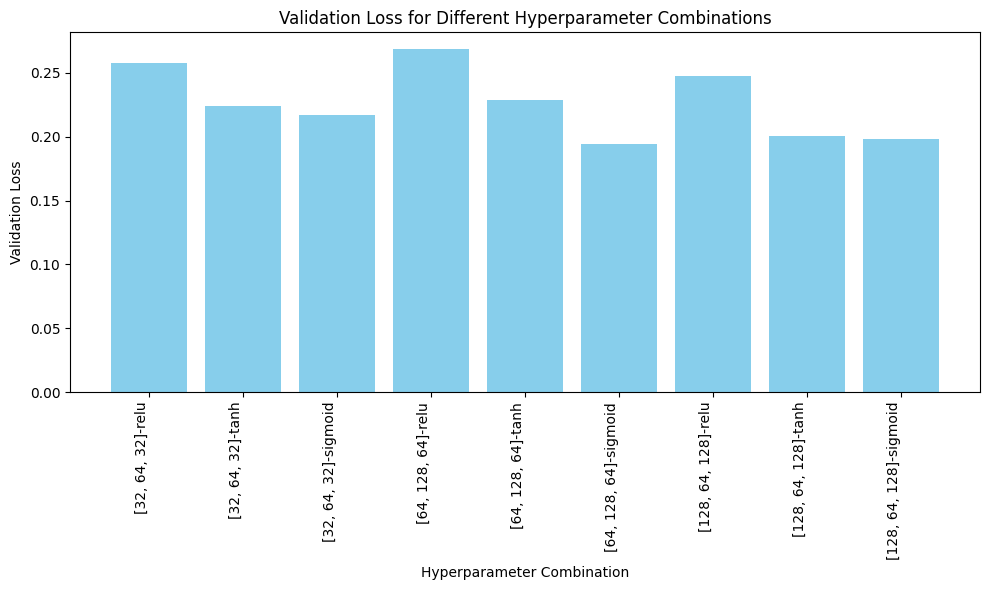

In [10]:
# Plot the validation losses
plt.figure(figsize=(10, 6))
x = np.arange(len(param_combos))  # x values for the bar chart
plt.bar(x, val_losses, color='skyblue')
plt.xticks(x, param_combos, rotation=90, ha='right')
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Hyperparameter Combinations")
plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def compute_performance_metrics(y_test, y_pred):
    # Compute R² score
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score: {r2:.4f}")

    # Compute Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae:.4f}")

    # Compute Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

In [21]:
# Predict on the test set
y_pred_nn = best_model.predict(X_test)
compute_performance_metrics(y_test, y_pred_nn)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² Score: 0.7696
Mean Absolute Error: 0.3072
Mean Squared Error: 0.1945


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
199    1.703225
420   -0.768936
694   -0.093017
750    0.898493
507    1.404531
         ...   
33     0.857123
31    -0.815172
711   -0.584509
299   -0.738354
616   -0.143736
Name: streams, Length: 191, dtype: float64


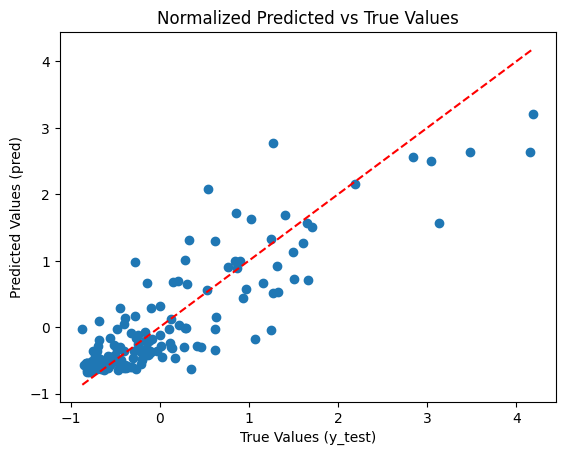

In [12]:
pred = best_model.predict(X_test)
pred = pred.flatten()
print(y_test)

plt.scatter(y_test, pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (pred)')
plt.title('Normalized Predicted vs True Values')
plt.show()

## SVM Model

In [22]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
mse_svr = [] 

# Perform cross-validation for each kernel
for kernel in kernels:
    svr = SVR(kernel=kernel)
    svr.fit(X_train, y_train)

    # Predict and evaluate the SVM model with kernel
    y_pred_svr = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_svr) 
    mse_svr.append(mse)

    print(f"Mean Squared Error for SVR model with {kernel}: {mse:.4f}")
    
# Identify the best kernel based on MSE
best_index = np.argmin(mse_svr)  # Minimize MSE
best_kernel = kernels[best_index]
print(f"\nBest kernel: {best_kernel} with MSE = {mse_svr[best_index]:.4f}")

Mean Squared Error for SVR model with linear: 0.2364
Mean Squared Error for SVR model with rbf: 0.2281
Mean Squared Error for SVR model with poly: 0.3038
Mean Squared Error for SVR model with sigmoid: 1.8377

Best kernel: rbf with MSE = 0.2281


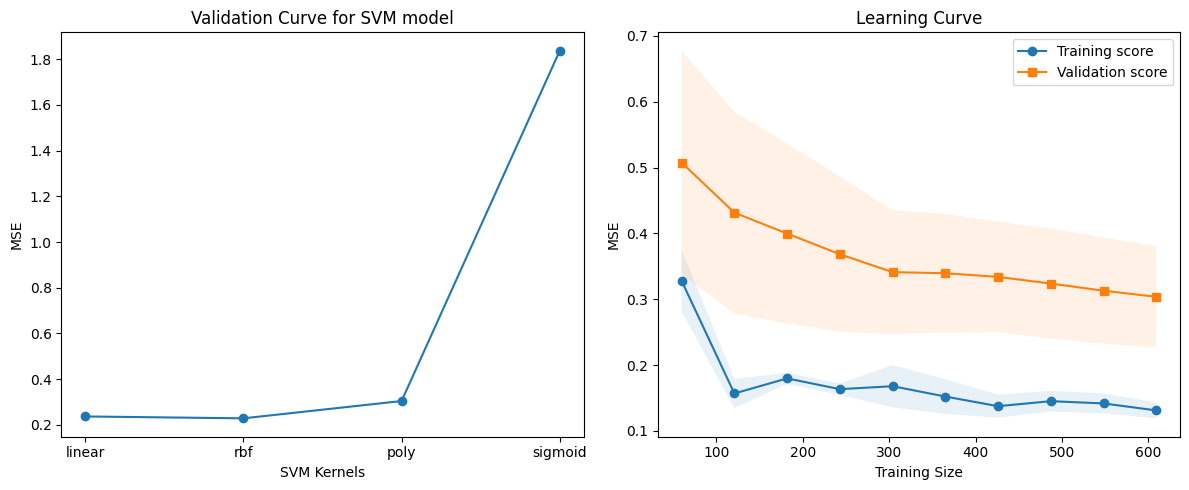

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(kernels, mse_svr, marker='o')
axes[0].set_xlabel('SVM Kernels')
axes[0].set_ylabel('MSE')
axes[0].set_title('Validation Curve for SVM model')

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    SVR(kernel=best_kernel),
    X_train, y_train,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    cv=5
)

train_scores, test_scores = -train_scores, -test_scores
# Compute mean and std for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
axes[1].plot(train_sizes, train_mean, label="Training score", marker='o')
axes[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[1].plot(train_sizes, test_mean, label="Validation score", marker='s')
axes[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Labels and title
axes[1].set_xlabel("Training Size")
axes[1].set_ylabel("MSE")
axes[1].set_title("Learning Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict on the test set
y_pred_svm = best_model.predict(X_test)
compute_performance_metrics(y_test, y_pred_nn)

## k-Nearest Neighbors Model

In [15]:
from sklearn.neighbors import KNeighborsRegressor

k_values = range(1, 26)
mse_knn = [] 

for k in k_values:
    # Create and train kNN model with k value
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict and evaluate the kNN model with k value
    y_pred_knn = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_knn) 
    mse_knn.append(mse)

    print(f"MSE of kNN with k={k}: {mse:.4f}")

best_index = np.argmin(mse_knn)
best_k = k_values[best_index]
print(f"\nBest k-value = {k_values[best_index]} with MSE = {mse_knn[best_index]:.4f}")
    

MSE of kNN with k=1: 0.6035
MSE of kNN with k=2: 0.4593
MSE of kNN with k=3: 0.3945
MSE of kNN with k=4: 0.4012
MSE of kNN with k=5: 0.4140
MSE of kNN with k=6: 0.4218
MSE of kNN with k=7: 0.4201
MSE of kNN with k=8: 0.4318
MSE of kNN with k=9: 0.4298
MSE of kNN with k=10: 0.4215
MSE of kNN with k=11: 0.4297
MSE of kNN with k=12: 0.4288
MSE of kNN with k=13: 0.4385
MSE of kNN with k=14: 0.4406
MSE of kNN with k=15: 0.4474
MSE of kNN with k=16: 0.4390
MSE of kNN with k=17: 0.4393
MSE of kNN with k=18: 0.4459
MSE of kNN with k=19: 0.4409
MSE of kNN with k=20: 0.4481
MSE of kNN with k=21: 0.4534
MSE of kNN with k=22: 0.4495
MSE of kNN with k=23: 0.4584
MSE of kNN with k=24: 0.4626
MSE of kNN with k=25: 0.4737

Best k-value = 3 with MSE = 0.3945


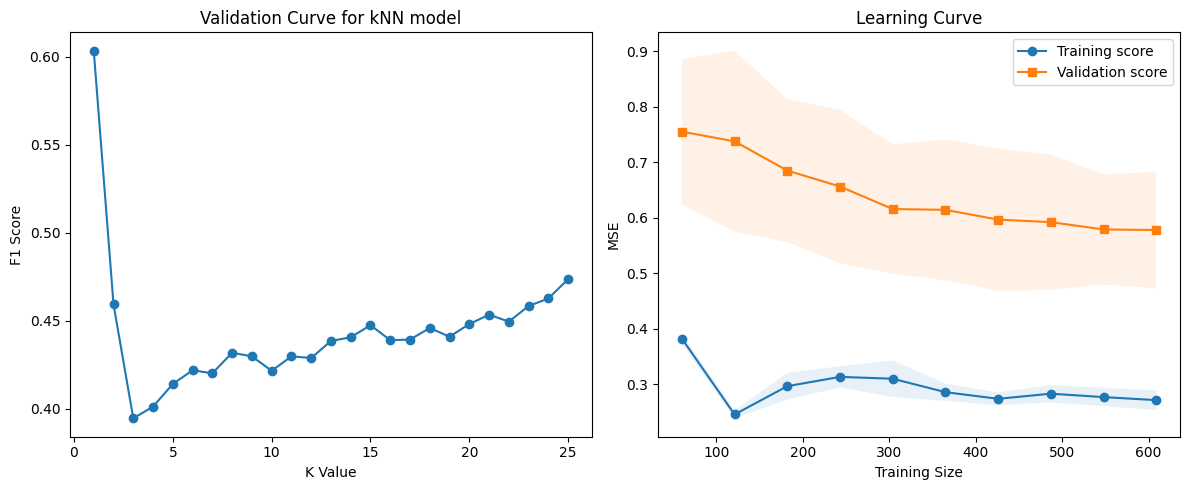

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(k_values, mse_knn, marker='o')
axes[0].set_xlabel('K Value')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Validation Curve for kNN model')

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    KNeighborsRegressor(n_neighbors=best_k),  
    X_train, y_train,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    cv=5
)

train_scores, test_scores = -train_scores, -test_scores

# Compute mean and std for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
axes[1].plot(train_sizes, train_mean, label="Training score", marker='o')
axes[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[1].plot(train_sizes, test_mean, label="Validation score", marker='s')
axes[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Labels and title
axes[1].set_xlabel("Training Size")
axes[1].set_ylabel("MSE")
axes[1].set_title("Learning Curve")
axes[1].legend()

plt.tight_layout()
plt.show()